In [1]:
rootf = './'

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
#---------------------------------
# # For clustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy as sc
# #---------------------------------
import sys
sys.path.append('./functions') 
from save_load import *
from functions_NO_MEA import*

Populating the interactive namespace from numpy and matplotlib


# Load data

In [3]:
from scipy.io import loadmat
import csv
Folder = rootf + 'data/TYPING_Baden/'
#-----------------------
# Baden data
baden = loadmat(Folder + 'baden_data.mat')
# #------------------------
chirp_stim = baden['chirp_stim'][:,0]/max(baden['chirp_stim'][:,0])
chirp_stim_time = baden['chirp_stim_time'][0,:] + 2   # 2 seconds later than my stim
baden_time_original = baden['chirp_time'][0,:]   # 2 seconds later than my stim
group_idx = baden['group_idx'] 
psth_euler = baden['chirp_avg']
#-------------------
euler_labels_f = open(Folder + 'Baden Types');
euler_labels_f = csv.reader(euler_labels_f,delimiter=",");
euler_labels={}
c=0
for row in euler_labels_f:
    if c==0:
        stim_cond_head = row
        c=1
    else:
        euler_labels[c-1]= row
        c+=1
#-------------------        

In [4]:
for i in euler_labels:
    print(euler_labels[i][0],i)

OFF local OS 0
OFF DS 1
OFF step 2
OFF slow 3
OFF alpha sustained 4
ON-OFF JAM-B 5
OFF sustained 6
OFF alpha transient 7
OFF mini alpha transient 8
ON-OFF local-edge W3 9
ON-OFF local 10
ON-OFF DS 1 11
ON-OFF DS 2 12
ON-OFF local OS 13
ON step 14
ON DS transient 15
ON local transient OS 16
ON transient 17
ON transient large 18
ON high frequency 19
ON low frequency 20
ON sustained 21
ON mini alpha 22
ON alpha 23
ON DS sustained 1 24
ON DS sustained 2 25
ON slow 26
ON constrast suppression 27
ON DS sustained 3 28
ON local sustained OS 29
OFF suppression 1 30
OFF suppression 2 31


### Stims

(-1, 2)

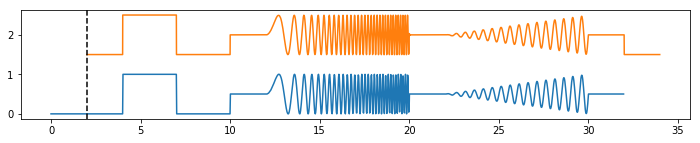

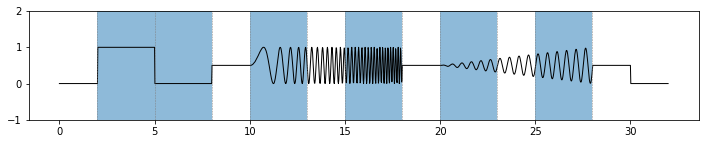

In [5]:
# Get Euler stim profile
def get_euler():
    vec_path = rootf + '/data/'
    vec_path = vec_path + r"chirp.vec"
    euler_vec = np.genfromtxt(vec_path)

    return (euler_vec[150:1750,1]/max(euler_vec[150:1750,1])) #return in 100ms steps

def get_euler2():
    vec_path = rootf + '/data/'
    vec_path = vec_path + r"chirp.vec"
    euler_vec = np.genfromtxt(vec_path)

    return (euler_vec[150+100:1750+100,1]/max(euler_vec[150+100:1750+100,1])) #return in 100ms steps

euler_vec= get_euler()

figure(figsize=(12,2))
time_stim = np.linspace(0,32,50*32+1)[:-1]
time = np.linspace(0,32,321)[:-1]
plot(time_stim,euler_vec)
euler_vec.shape
euler_vec[::5].shape,time.shape
# ylim([0,1])
plot(chirp_stim_time ,chirp_stim+1.5)
chirp_stim_time.shape, chirp_stim.shape
axvline(2,linestyle='--',color='k')

# comparison range:
comp_range = [0.1,31.9]         # to avoid prestep effects
delta_range = comp_range[1]-comp_range[0]
time_common = np.linspace(comp_range[0],comp_range[1],int(delta_range/0.05) +2)
#--------------------------------
# New Euler stim as Calcium traces
figure(figsize=(12,2))
euler_vec2 = get_euler2() 
plot(time_stim,euler_vec2,lw=1,color='k')

for l in [2,5,8,10,13,15,18,20,23,25,28]:
    axvline(l,linestyle='--',color='gray',lw=0.5)
Vregions = [[2,5],[5,8],[10,13],[15,18],[20,23],[25,28]]
for v in Vregions:
    axvspan(v[0], v[1], alpha=0.5)
ylim(-1,2)

### Euler calcium data

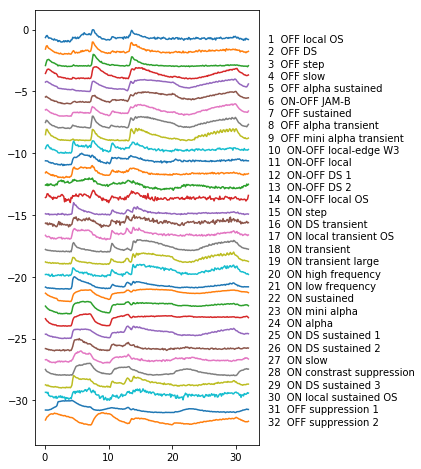

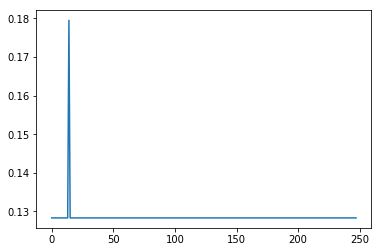

In [6]:
# Generate Baden type traces
baden_time = baden_time_original+2
baden_first = baden_time[-15:]-32
baden_time=np.append(baden_first,baden_time[:-15])


Baden_types = []
figure(figsize=(4,8))
for i in np.arange(32)+1:
    trace = np.mean(psth_euler[:,(group_idx==i)[:,0]],1)
    trace = trace-min(trace)
    trace = trace/max(trace)
    trace = np.append(trace[-15:],trace[:-15])                # I stitch las 2 s in the beggining so that it is 
                                                              #  the same as my experimental stim
    Baden_types.append(trace)
    plot(baden_time,trace-i)
    text(35,-i,str(i)+'  '+euler_labels[i-1][0])

figure()
plot(diff(baden_time))

### Experiment to calcium data

In [7]:
# experiment data
Fsave = rootf + '/data/MEA_Data/pckls_ID/'
fsave = Fsave + 'clustermodel32'
model, psth_z = load_obj(fsave)

labels = model.labels_
exp_labels = np.sort(np.unique(labels))
psth_z.shape, 'Ncells  - Ndatapoints'

((54, 320), 'Ncells  - Ndatapoints')

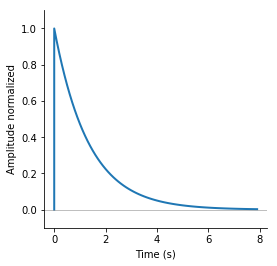

In [8]:
# functions for calcium traces
def calcium_exp(x):
    a =           0
    b =       1.086 
    c =       1.747 -1.0              
    val = a+b*np.exp(-c*x)
    return val

def toCalciumLinear(time_sequence, spike_train):
    calcium_filter = calcium_exp(time_sequence);
    
    stitch3 = np.append(spike_train,[spike_train,spike_train])
    
    calcium_trace = np.convolve(stitch3, calcium_filter, 'full')[len(spike_train):len(spike_train)*2];
    calcium_trace = calcium_trace-min(calcium_trace)
    calcium_trace=calcium_trace/max(calcium_trace)
    return calcium_trace

span = 80

fig=figure(figsize = (4,4))

ax=fig.add_subplot(1,1,1)

calcium_filter = calcium_exp(time);

ax.plot(np.append([0],time[0:span]),np.append([0],calcium_filter[0:span])/max(calcium_filter),lw=2)

ax.set_ylim(-0.1,1.1)
ax.axhline(0,color='gray',lw=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Amplitude normalized')
ax.set_xlabel('Time (s)')

PDFsave = rootf + '/OUTPUT_NO_MEA/'
fsave = PDFsave + 'Exp_transform'
# fsave = PDFsave + 'Exp_transform_baden'
fig.savefig(fsave + '.pdf',format='pdf')

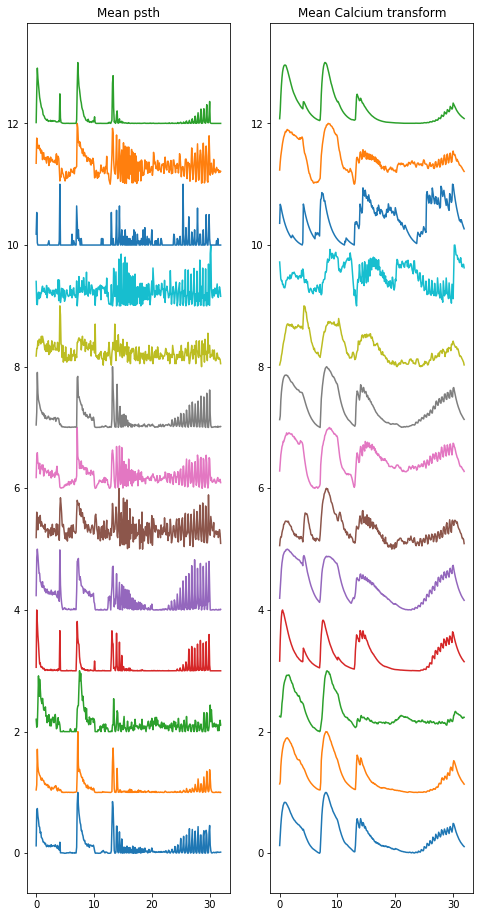

In [20]:
# Generate experiment type traces
Exp_types = []
fig = figure(figsize=(8,16))
fig.add_subplot(1,2,1)
for i in exp_labels:
    trace = np.mean(psth_z[(labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_types.append(trace)
    plot(time,trace+i)
    title('Mean psth')

# Experiment to calcium
Exp_types_Ca = {}
fig.add_subplot(1,2,2)
for i in exp_labels:
    trace = toCalciumLinear(time,Exp_types[i])
    Exp_types_Ca[i] = trace
    plot(time,trace+i)
    title('Mean Calcium transform')

# Manual selection of Groups

In [21]:
Fsave = rootf + '/data/MEA_Data/pckls_ID/'
fsave = Fsave +  'group32_celldataID'
cell_data = load_obj(fsave)

fsave = Fsave + 'selected_cells32'
selected_cells = load_obj(fsave)

In [22]:
selected_cells

{0: [4, 7, 206],
 1: [4, 9, 255],
 2: [4, 21, 367],
 3: [4, 34, 580],
 4: [4, 45, 776],
 5: [4, 50, 894],
 6: [4, 57, 967],
 7: [4, 58, 995],
 8: [4, 59, 998],
 9: [4, 60, 999],
 10: [4, 63, 1012],
 11: [4, 64, 1020],
 12: [4, 66, 1026],
 13: [4, 70, 1042],
 14: [4, 88, 1116],
 15: [5, 1, 205],
 16: [5, 6, 518],
 17: [5, 8, 640],
 18: [5, 13, 859],
 19: [5, 16, 1153],
 20: [5, 23, 1238],
 21: [5, 24, 1281],
 22: [7, 17, 167],
 23: [7, 22, 190],
 24: [7, 23, 208],
 25: [7, 36, 501],
 26: [7, 37, 529],
 27: [7, 44, 601],
 28: [7, 46, 639],
 29: [7, 49, 680],
 30: [7, 56, 776],
 31: [7, 60, 787],
 32: [7, 70, 935],
 33: [7, 76, 970],
 34: [7, 85, 1026],
 35: [7, 87, 1044],
 36: [7, 105, 1096],
 37: [7, 114, 1150],
 38: [7, 121, 1168],
 39: [7, 140, 1244],
 40: [7, 148, 1322],
 41: [8, 17, 188],
 42: [8, 26, 249],
 43: [8, 30, 281],
 44: [8, 39, 398],
 45: [8, 42, 455],
 46: [8, 44, 458],
 47: [8, 45, 461],
 48: [8, 49, 515],
 49: [8, 66, 648],
 50: [8, 70, 694],
 51: [8, 71, 695],
 52: [8

# New cluster labels

In [23]:
# My list of group cells

Groups = []

Groups.append([0,7])           # Cluster 1
Groups.append([5,6,9,11])        # Cluster 2
Groups.append([1,12])            # Cluster 3
Groups.append([3]) # Reassigned to Type OFF ALPHA TRANSIENT, Group 9
Groups.append([4]) # discarded
Groups.append([2,8,10]) #Bad groups

new_labels = np.zeros(len(model.labels_))

for g,groups in enumerate(Groups):
    for n in groups:
        clustersin = [np.where((model.labels_==n))[0]][0]
        for j in clustersin:
            new_labels[j]=g

 #####################################3
# here assign label to each cluster
Dic_labels={}
for i in np.arange(len(new_labels)):
    if new_labels[i]!=-1:
        Dic_labels.update({list(selected_cells)[i]: euler_labels[new_labels[i]]})
#--------------------
for c in sorted(list(Dic_labels.keys())):
     print('Clus ',c, '   Baden ',Dic_labels[c])
    

Clus  0    Baden  ['OFF DS']
Clus  1    Baden  ['OFF local OS']
Clus  2    Baden  ['OFF DS']
Clus  3    Baden  ['OFF DS']
Clus  4    Baden  ['OFF step']
Clus  5    Baden  ['OFF DS']
Clus  6    Baden  ['OFF local OS']
Clus  7    Baden  ['OFF DS']
Clus  8    Baden  ['ON-OFF JAM-B']
Clus  9    Baden  ['OFF DS']
Clus  10    Baden  ['OFF step']
Clus  11    Baden  ['OFF DS']
Clus  12    Baden  ['OFF local OS']
Clus  13    Baden  ['OFF step']
Clus  14    Baden  ['OFF local OS']
Clus  15    Baden  ['OFF DS']
Clus  16    Baden  ['OFF local OS']
Clus  17    Baden  ['OFF local OS']
Clus  18    Baden  ['OFF DS']
Clus  19    Baden  ['OFF DS']
Clus  20    Baden  ['OFF local OS']
Clus  21    Baden  ['OFF local OS']
Clus  22    Baden  ['OFF step']
Clus  23    Baden  ['OFF step']
Clus  24    Baden  ['OFF step']
Clus  25    Baden  ['OFF local OS']
Clus  26    Baden  ['OFF local OS']
Clus  27    Baden  ['OFF local OS']
Clus  28    Baden  ['OFF slow']
Clus  29    Baden  ['OFF slow']
Clus  30    Baden  ['O

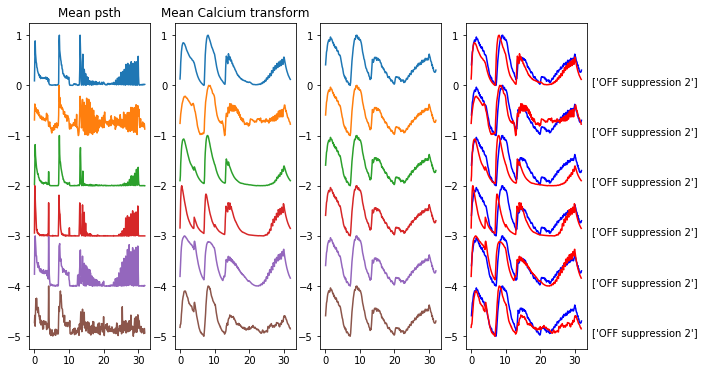

In [24]:
# Generate new experiment type traces
Exp_sorted_types = []
fig = figure(figsize=(10,6))
fig.add_subplot(1,4,1)
for i in list(euler_labels.keys())[0:6]:
    trace = np.mean(psth_z[(new_labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_sorted_types.append(trace)
    plot(time,trace-i)
    title('Mean psth')
    ylim([-5.25,1.25])
    
# Experiment to calcium
Exp_sorted_types_Ca = {}
fig.add_subplot(1,4,2)
for i in list(euler_labels.keys())[0:6]:
    trace = toCalciumLinear(time,Exp_sorted_types[i])
    Exp_sorted_types_Ca[i] = trace
    plot(time,trace-i)
    title('Mean Calcium transform')
    ylim([-5.25,1.25])
fig.add_subplot(1,4,3)

for i in list(euler_labels.keys())[0:6]:
        plot(baden_time,Baden_types[31]-i)
        ylim([-5.25,1.25])
        
fig.add_subplot(1,4,4)
for i in list(euler_labels.keys())[0:6]:
        plot(baden_time,Baden_types[31]-i,'b')
        plot(time,Exp_sorted_types_Ca[i]-i,'r')
        text(35,-i,euler_labels[31])
        ylim([-5.25,1.25])

# Create a summary figure for each cluster type

17


/Users/matias/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


10
15


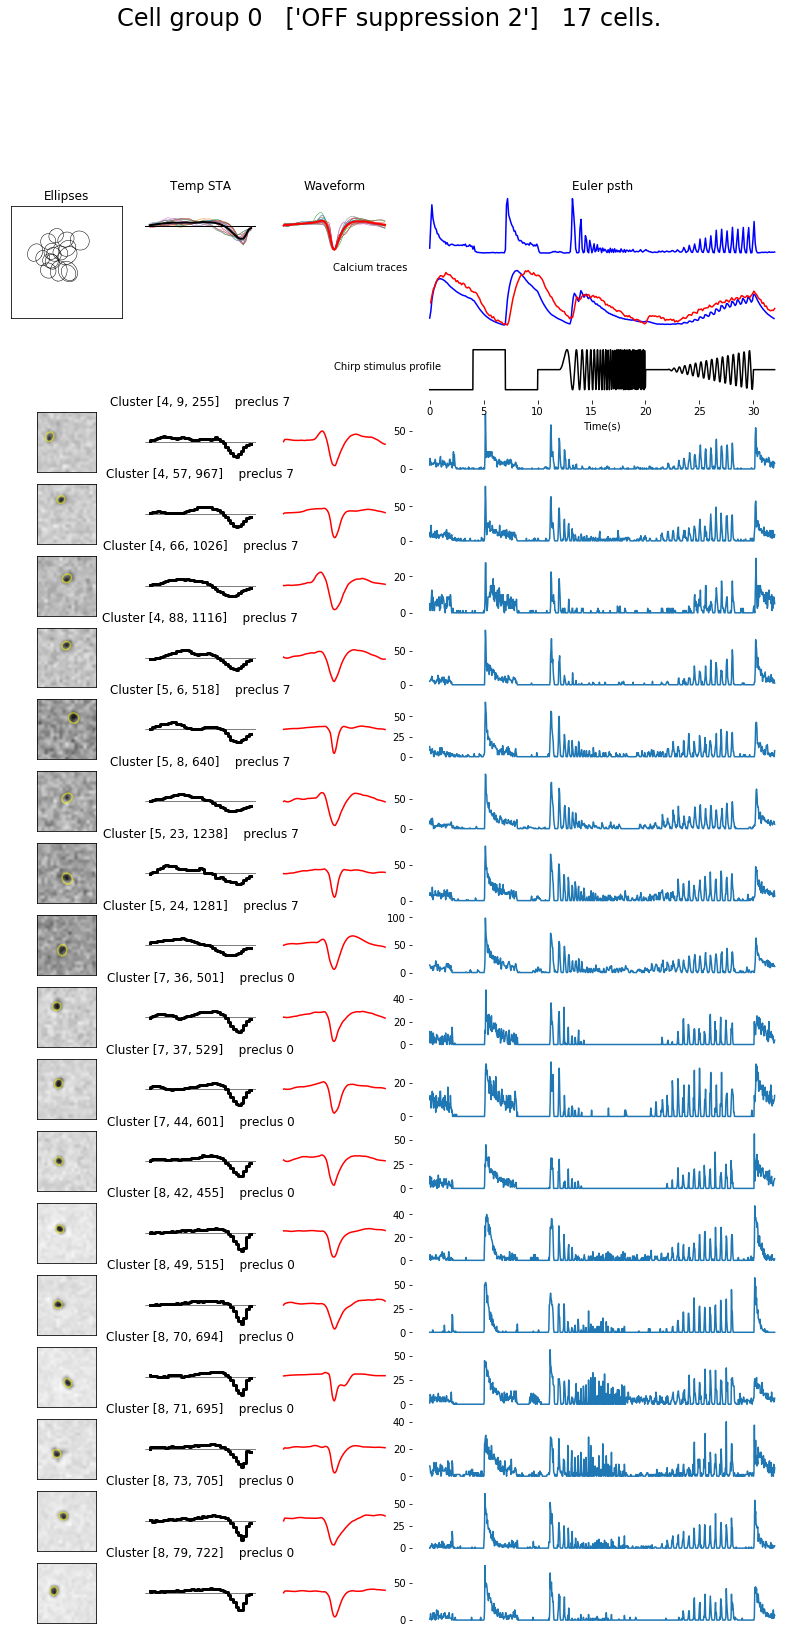

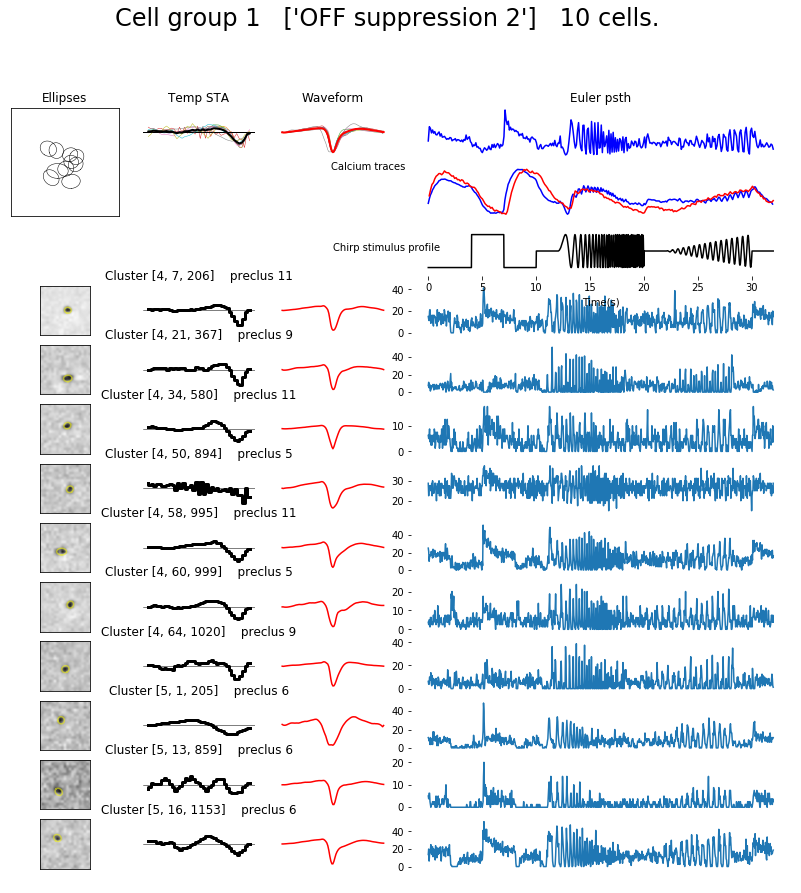

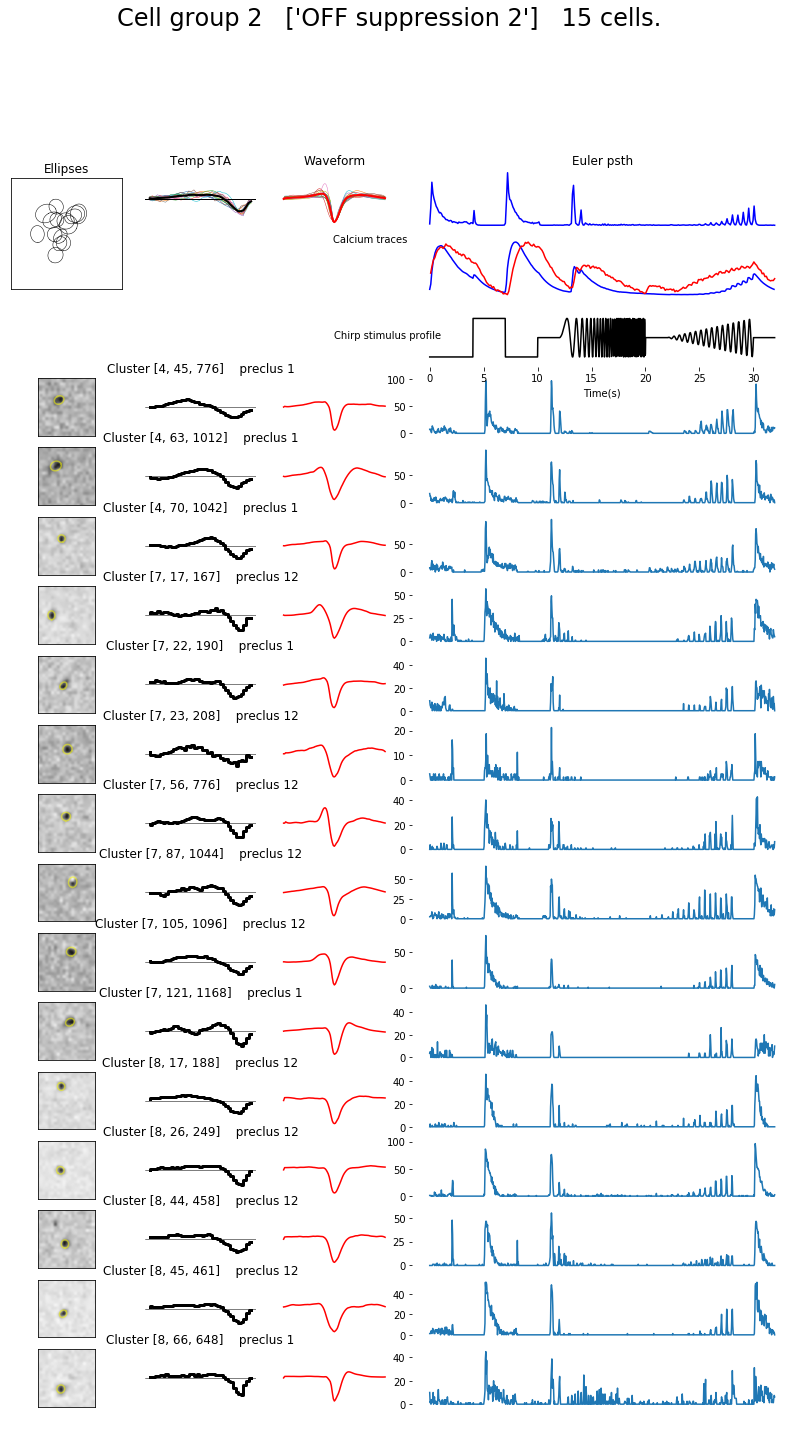

In [25]:
#-------------------------------------------------------

from matplotlib import gridspec

# for icluster in range(len(euler_labels))[0:]:
for icluster in [0,1,2]:#[3,,4,5]:

    #idx_cluster = np.where(model.labels_==icluster)[0]
    idx_cluster = np.where(new_labels==icluster)[0]
    print(len(idx_cluster))

    gs = gridspec.GridSpec(len(idx_cluster)+3,6)
    
    #subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
    if len(idx_cluster)<7:
        yspan = 2
    else:
        yspan=-2
    fig=figure(figsize=(14,(len(idx_cluster)+yspan)*1.75))
    #axs = fig.add_subplot(nrows=len(idx_cluster)+1, ncols=3, figsize=(16,16))
    plt.suptitle("Cell group {}   {}   {} cells.".format(icluster,euler_labels[31], len(idx_cluster)),size=24)

    #-------------------------------
    # Loop cells in cluster
    line = 2
    STAs=np.zeros(40)
    STAcount=0
    waves=np.zeros(101)
    wavecount=0
    
    for index in sorted(idx_cluster):
        cell_nb = index#list(selected_cells).index(index)
        
        exp,cell_idx, cell_name = selected_cells[cell_nb]
                
        #-----------------
        # Plot temp STA
        ax= subplot(gs[line+1,1])
        
        ax.set_ylim([-0.85,0.85])
        ax.axis("off")
#         ax.set_aspect(0.075)
        ax.step(np.linspace(-40/30,0,40),cell_data[exp][cell_idx]["temporal_sta_c1"],'k',lw=3)
        polarity = cell_data[exp][cell_idx]["polarity_c1"]
        ax.set_title('Cluster ' + str(selected_cells[cell_nb]) + '    preclus '+str(model.labels_[cell_nb]))
        ax.axhline(0,color='k',lw=0.5)
        
        STAs+=cell_data[exp][cell_idx]["temporal_sta_c1"]
        STAcount+=1
        
        #-----------------
        # Plot temp STA avg
        ax= subplot(gs[0,1])
        
        ax.set_title('Temp STA')
        ax.set_ylim([-0.85,0.85])
        ax.plot(np.linspace(-40/30,0,40),cell_data[exp][cell_idx]["temporal_sta_c1"],lw=0.5)
        ax.axhline(0,color='k',lw=0.5)
        ax.set_xlabel('Time(s)')
        
        #-----------------
        # plot Spatial STA
        ax= subplot(gs[line+1,0])
                
        ax.imshow(cell_data[exp][cell_idx]["spatial_sta_c1"], cmap='gray',interpolation='gaussian')
        ax.set_xlim(15,35)
        ax.set_ylim(35,15)
        ax.set_aspect('equal')
        #ax.set_title('Cluster' + str(cell_nb))
        ax.set_xticks([])
        ax.set_yticks([])
       
        #----------------
        #plot waveform
        ax= subplot(gs[line+1,2])
        
        wave = cell_data[exp][cell_idx]["templates"]/abs(np.min(cell_data[exp][cell_idx]["templates"]))
        ax.plot(wave,'r')
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        waves+=wave
        wavecount+=1
        
        ax= subplot(gs[0,2])
        ax.plot(wave,lw=0.5)
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        #-----------------
        # plot Euler
        ax= subplot(gs[line+1,3:])
        
#         cell_index=list(selected_cells).index(cell_nb)
        cell_index=cell_nb
    
        psth= cell_data[exp][cell_idx]["psth_c1"]                 # to shift it
        psth=np.append(psth[50:],psth[0:50])
        
        ax.plot(np.linspace(0,32,800),psth)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        plt.locator_params(axis="y", nbins=3)
        
        ax= subplot(gs[line+1,0])
        ax.plot(cell_data[exp][cell_idx]['ellipseMat_c1'][0]   , cell_data[exp][cell_idx]['ellipseMat_c1'][1] ,'yellow',alpha=0.5 )#,lw=10)    #rotated ellipse
        ax= subplot(gs[0:2,0])
        ax.plot(cell_data[exp][cell_idx]['ellipseMat_c1'][0]   , cell_data[exp][cell_idx]['ellipseMat_c1'][1] ,'k' ,lw=0.5)#,lw=10)    #rotated ellipse
        
        line+=1
    
    #-----------------
    # avg STA
    STAs=STAs/STAcount
    ax= subplot(gs[0,1])
    ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
    ax.set_ylim([-0.85,0.85])
#     ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # avg wave
    waves=waves/wavecount
    ax= subplot(gs[0,2])
    ax.set_title('Waveform')
    
    ax.plot(waves,'r',lw=2)
    ax.set_ylim([-1.25,1.25])
    #ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # size ellipses
    ax= subplot(gs[0:2,0])
    
    ax.set_title('Ellipses')
    ax.set_xlim(15,35)
    ax.set_ylim(35,15)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
        
    #-----------------
    # mean psth
    ax= subplot(gs[0,3:])
    ax.set_title('Euler psth')
    
    ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'b')
    ax.axis("off")
    
    #-----------------
    # mean Ca trace + comparison
    ax= subplot(gs[1,3:])
    ax.text(-9,1,'Calcium traces')
    ax.axis("off")
            
    plot(time,Exp_sorted_types_Ca[icluster] ,'b')
    plot(baden_time,Baden_types[31],'r')

      
    #-----------------
    # plot euler stim
    euler_vec= get_euler()
    ax= subplot(gs[2,3:])
    
    ax.plot(time_stim,euler_vec, color='k')
    ax.set_yticks([])
    ax.set_ylim([-0.25,1.25])
    ax.set_xlabel('Time(s)')
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax= subplot(gs[2,2])
    ax.text(0.5,0.5 ,"Chirp stimulus profile")
    ax.axis("off")
    
    
    new_labels[j]
    PDF_folder = rootf + 'OUTPUT_NO_MEA/Cell_type32/Done/'
    fsave = PDF_folder + 'Final_type32_clustype' +str(icluster) 
    
#     fig.savefig(fsave+'.png',format='png',dpi=250)
    fig.savefig(fsave+'.pdf',format='pdf')

#     close(fig)    


# plot_per_experiment

17


/Users/matias/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
/Users/matias/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


10


/Users/matias/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in true_divide
/Users/matias/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in true_divide


15
5
3
4


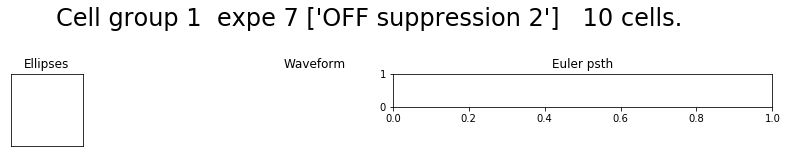

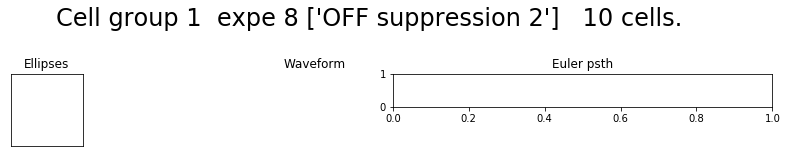

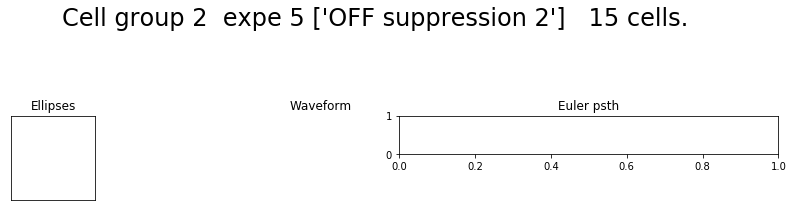

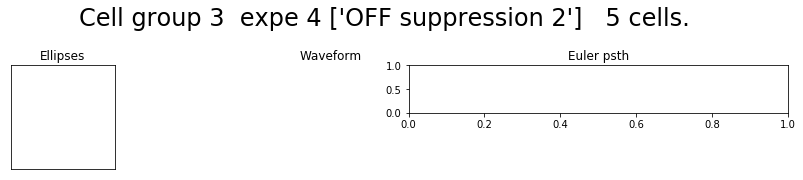

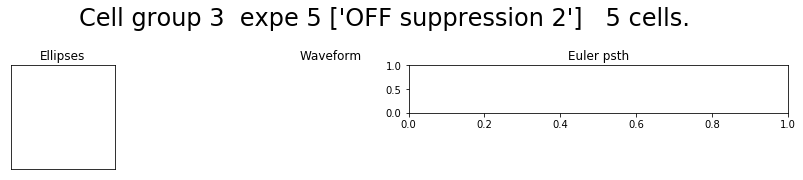

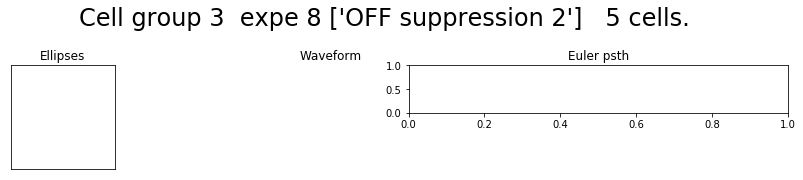

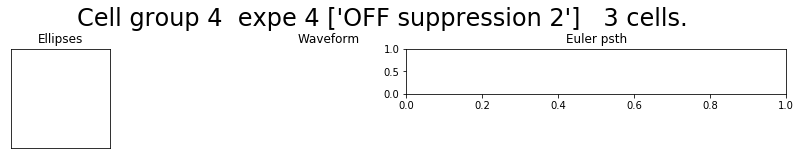

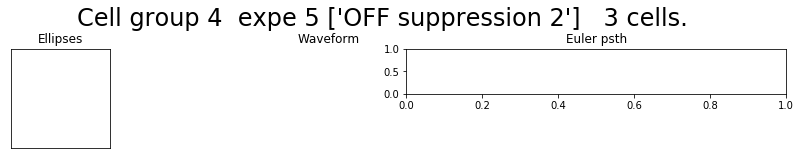

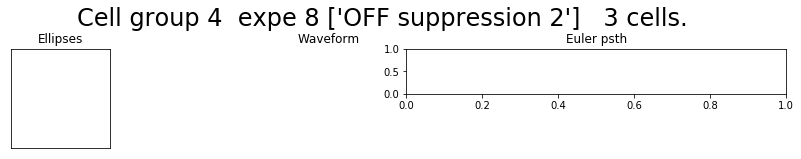

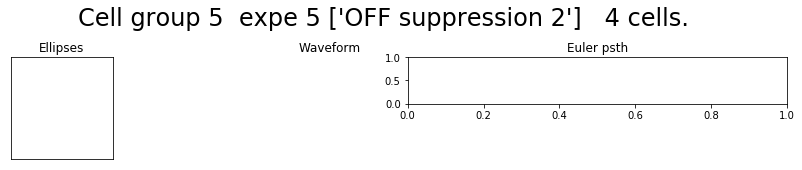

In [32]:
#-------------------------------------------------------
n_rep = 20 # nb of repeats
nt = 32 # total length
dt = 0.1 # bin size
time_bins = np.arange(0,nt+dt,dt)

time320=np.linspace(0,32,321)[:-1]
#-------------------------
# Pre process the PSTH
def make_psth320(spikes):
    spikes = np.concatenate(np.array(spikes), axis=0)
    psth=np.histogram(spikes, bins=time_bins)[0]
    return psth
#-------------------------

from matplotlib import gridspec
Exp_type_exp = {}
for icluster in [0,1,2,3,4,5]:
    Exp_type_exp[icluster]={}
    Exp_type_exp[icluster][4]=[]
    Exp_type_exp[icluster][5]=[]
    Exp_type_exp[icluster][7]=[]
    Exp_type_exp[icluster][8]=[]
   
# for icluster in range(len(euler_labels))[0:]:
for icluster in [0,1,2,3,4,5]:
    
    #idx_cluster = np.where(model.labels_==icluster)[0]
    idx_cluster = np.where(new_labels==icluster)[0]
    print(len(idx_cluster))

    gs = gridspec.GridSpec(int(len(idx_cluster))+3,6)
    if icluster in [4,5]: gs = gridspec.GridSpec(int(len(idx_cluster))+3,6)
    
    #subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
    if len(idx_cluster)<7:
        yspan = 2
    else:
        yspan=-2
        
    for expe in [4,5,7,8]:
        fig=figure(figsize=(14,(len(idx_cluster)+yspan)*1.75/1.5))
        #axs = fig.add_subplot(nrows=len(idx_cluster)+1, ncols=3, figsize=(16,16))
        plt.suptitle("Cell group {}  expe {} {}   {} cells.".format(icluster,expe,euler_labels[31], len(idx_cluster)),size=24)

        #-------------------------------
        # Loop cells in cluster
        line = 2
        STAs=np.zeros(40)
        STAcount=0
        waves=np.zeros(101)
        wavecount=0
        for index in sorted(idx_cluster):
            cell_nb = index#list(selected_cells).index(index)

            exp,cell_idx, cell_name = selected_cells[cell_nb]
            
            if expe!=exp:
                continue
            psth320=make_psth320(cell_data[exp][cell_idx]['chirp_spike_trains_c1'])
            Exp_type_exp[icluster][expe].append(psth320)
            #-----------------
            # Plot temp STA
            ax= subplot(gs[line+1,1])

            ax.set_ylim([-0.85,0.85])
            ax.axis("off")
    #         ax.set_aspect(0.075)
            ax.step(np.linspace(-40/30,0,40),cell_data[exp][cell_idx]["temporal_sta_c1"],'k',lw=3)
            polarity = cell_data[exp][cell_idx]["polarity_c1"]
            ax.set_title('Cluster ' + str(selected_cells[cell_nb]) + '    preclus '+str(model.labels_[cell_nb]))
            ax.axhline(0,color='k',lw=0.5)

            STAs+=cell_data[exp][cell_idx]["temporal_sta_c1"]
            STAcount+=1

            #-----------------
            # Plot temp STA avg
            ax= subplot(gs[0,1])

            ax.set_title('Temp STA')
            ax.set_ylim([-0.85,0.85])
            ax.plot(np.linspace(-40/30,0,40),cell_data[exp][cell_idx]["temporal_sta_c1"],lw=0.5)
            ax.axhline(0,color='k',lw=0.5)
            ax.set_xlabel('Time(s)')

            #-----------------
            # plot Spatial STA
            ax= subplot(gs[line+1,0])

            ax.imshow(cell_data[exp][cell_idx]["spatial_sta_c1"], cmap='gray',interpolation='gaussian')
            ax.set_xlim(15,35)
            ax.set_ylim(35,15)
            ax.set_aspect('equal')
            #ax.set_title('Cluster' + str(cell_nb))
            ax.set_xticks([])
            ax.set_yticks([])

            #----------------
            #plot waveform
            ax= subplot(gs[line+1,2])

            wave = cell_data[exp][cell_idx]["templates"]/abs(np.min(cell_data[exp][cell_idx]["templates"]))
            ax.plot(wave,'r')
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])
            waves+=wave
            wavecount+=1

            ax= subplot(gs[0,2])
            ax.plot(wave,lw=0.5)
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])
            #-----------------
            # plot Euler
            ax= subplot(gs[line+1,3:])

    #         cell_index=list(selected_cells).index(cell_nb)
            cell_index=cell_nb
            ax.plot(np.linspace(0,32,800),cell_data[exp][cell_idx]["psth_c1"])
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            plt.locator_params(axis="y", nbins=3)

            ax= subplot(gs[line+1,0])
            ax.plot(cell_data[exp][cell_idx]['ellipseMat_c1'][0]   , cell_data[exp][cell_idx]['ellipseMat_c1'][1] ,'yellow',alpha=0.5 )#,lw=10)    #rotated ellipse
            ax= subplot(gs[0:2,0])
            ax.plot(cell_data[exp][cell_idx]['ellipseMat_c1'][0]   , cell_data[exp][cell_idx]['ellipseMat_c1'][1] ,'k' ,lw=0.5)#,lw=10)    #rotated ellipse

            line+=1
                    
        #-----------------
        # avg STA
        STAs=STAs/STAcount
        ax= subplot(gs[0,1])
        ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
        ax.set_ylim([-0.85,0.85])
    #     ax.set_aspect(0.075)
        ax.axis("off")

        #-----------------
        # avg wave
        waves=waves/wavecount
        ax= subplot(gs[0,2])
        ax.set_title('Waveform')

        ax.plot(waves,'r',lw=2)
        ax.set_ylim([-1.25,1.25])
        #ax.set_aspect(0.075)
        ax.axis("off")

        #-----------------
        # size ellipses
        ax= subplot(gs[0:2,0])

        ax.set_title('Ellipses')
        ax.set_xlim(15,35)
        ax.set_ylim(35,15)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        #-----------------
        # mean psth
        ax= subplot(gs[0,3:])
        ax.set_title('Euler psth')

        if len(Exp_type_exp[icluster][expe])==0: continue
        ax.plot(np.linspace(0,32,320),np.mean(Exp_type_exp[icluster][expe],axis=0),'b')
        #ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'b')
        
        ax.axis("off")

        #-----------------
        # mean Ca trace + comparison
        ax= subplot(gs[1,3:])
        ax.text(-9,1,'Calcium traces')
        ax.axis("off")

        Exp_type = toCalciumLinear(time320,np.mean(Exp_type_exp[icluster][expe],axis=0))
        plot(time,Exp_type ,'b')
        
#         plot(time,Exp_sorted_types_Ca[icluster] ,'b')
        plot(baden_time,Baden_types[31],'r')

        #-----------------
        # plot euler stim
        euler_vec= get_euler()
        ax= subplot(gs[2,3:])

        ax.plot(time_stim,euler_vec, color='k')
        ax.set_yticks([])
        ax.set_ylim([-0.25,1.25])
        ax.set_xlabel('Time(s)')
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax= subplot(gs[2,2])
        ax.text(0.5,0.5 ,"Chirp stimulus profile")
        ax.axis("off")

        #----------------------------------------------
        #----------------------------------------------
        PDF_folder = rootf + '/OUTPUT_NO_MEA/Cell_type32/Done/'
        fsave = PDF_folder + 'Final_type32_clustype' +str(icluster) +'_exp'+str(expe)

        fig.savefig(fsave+'.png',format='png',dpi=250)

        close(fig)    


# SAVE DATA

In [33]:
Fsave = rootf + '/data/MEA_Data/pckls_ID/'
fsave = Fsave + 'celltype_baden32'
save_obj(new_labels,fsave)


Fsave = rootf + '/data/MEA_Data/pckls_ID/'
fsave = Fsave + 'celltype_exp32_Ca_traces'
save_obj(Exp_sorted_types_Ca,fsave)
